In [110]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy.linalg import svd, norm
import scipy

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

import net_helpers
import mpn_tasks
import helper
import mpn
import clustering

c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] * 10

In [111]:
basepath = "./pretraining"
stage1_name1 = "fdanti"
stage1_name2 = "delaygo"
final_name = "delayanti"

seed = 127
N = 300
filepath = f"output_{stage1_name1}_{stage1_name2}_seed{seed}_+hidden{N}+batch128+stimulus"
parampath = f"param_{stage1_name1}_{stage1_name2}_seed{seed}_+hidden{N}+batch128+stimulus"

stage1_output_path = f"{basepath}/{filepath}_stage1.npz"
stage2_output_path = f"{basepath}/{filepath}_stage2.npz"
final_param_path = f"{basepath}/{parampath}_result.npz"

stage1_output = np.load(stage1_output_path, allow_pickle=True)
stage2_output = np.load(stage2_output_path, allow_pickle=True)
final_param = np.load(final_param_path, allow_pickle=True)

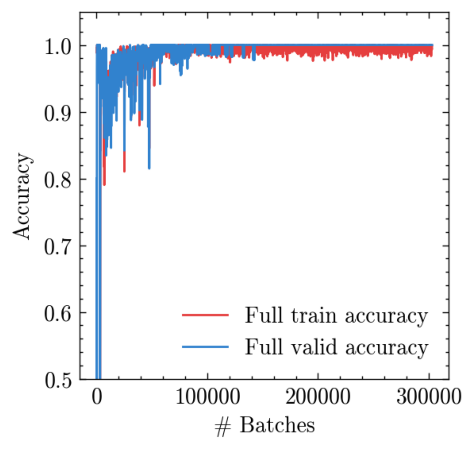

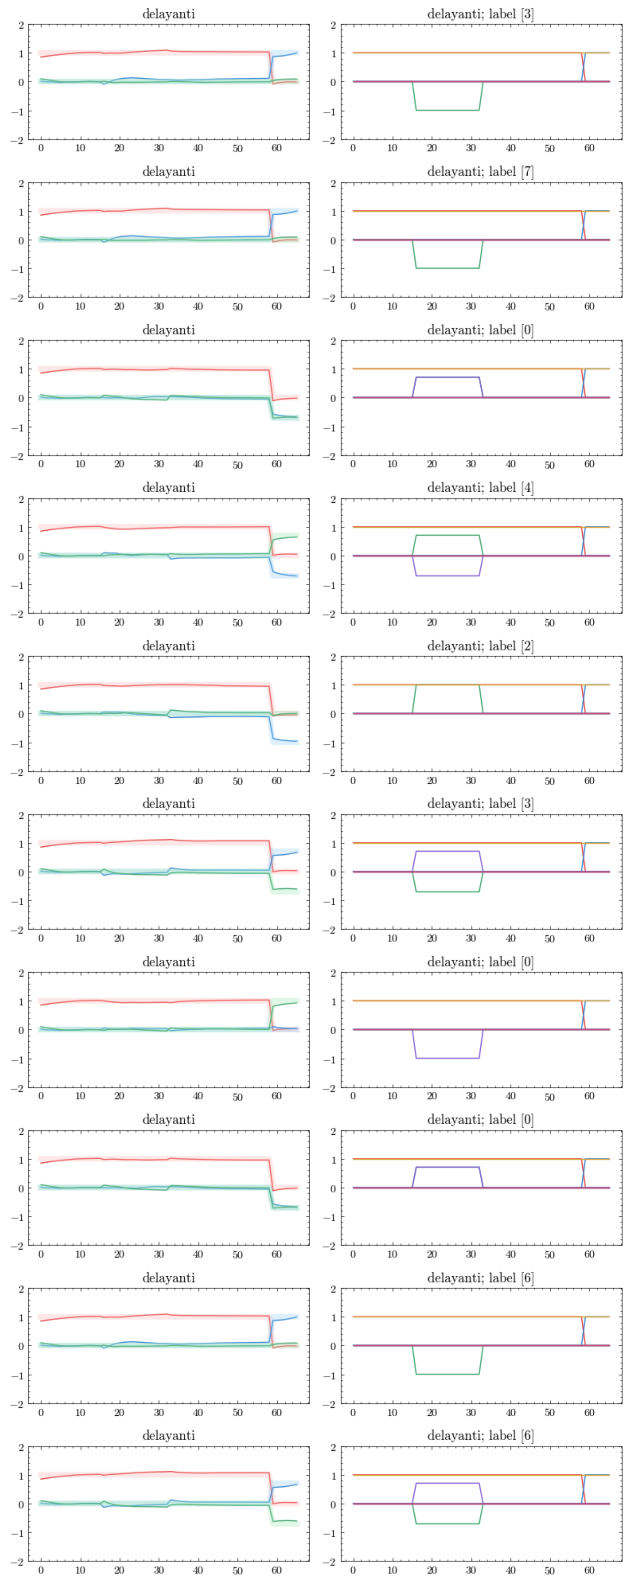

In [112]:
from pathlib import Path
from PIL import Image

def find_pngs_with_components(root, components, recursive=True, case_sensitive=False):
    """
    Return a list of Paths to .png files whose *filenames* contain all substrings in `components`.
    """
    root = Path(root)
    if not case_sensitive:
        components = [c.lower() for c in components]

    candidates = root.rglob("*.png") if recursive else root.glob("*.png")
    matches = []
    for p in candidates:
        name = p.name if case_sensitive else p.name.lower()
        if all(c in name for c in components):
            matches.append(p)

    matches.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return matches

def show_image(path, size=(6,6)):
    img = Image.open(path)
    fig, ax = plt.subplots(1,1,figsize=size)
    ax.imshow(img)
    ax.axis('off')
    fig.show()

search_root = "./pretraining/"

components_loss = ["loss", f"seed{seed}"]    
matches_loss = find_pngs_with_components(search_root, components_loss,
                                    recursive=True, case_sensitive=False)
show_image(matches_loss[0])

components_showcase = ["lowD", f"seed{seed}"]    
matches_showcase = find_pngs_with_components(search_root, components_showcase,
                                    recursive=True, case_sensitive=False)
show_image(matches_showcase[0], size=(4*2,4*20))

In [113]:
all_rule_info = final_param['rules_epochs']

In [114]:
final_param.files

['rules_epochs',
 'rules_epochs2',
 'hyp_dict_old',
 'hyp_dict',
 'all_rules',
 'Ms_orig_stage1',
 'hs_stage1',
 'bs_stage1',
 'xs_stage1',
 'Ms_orig_stage2',
 'hs_stage2',
 'bs_stage2',
 'xs_stage2']

In [115]:
stage1_output.files

['test_input_np',
 'net_out_stage1_final',
 'test_output_np',
 'rules_epochs',
 'task_params',
 'test_task']

In [116]:
stage2_output.files

['test_input_np',
 'net_out_final',
 'test_output_np',
 'rules_epochs2',
 'task_params',
 'test_task']

In [117]:
len(stage2_output["test_task"])

50

In [118]:
test_task = stage1_output["test_task"]
stage1_op = final_param["hs_stage1"]
stage2_op = final_param["hs_stage2"]
stage1_rules_epochs = stage1_output["rules_epochs"].item()
stage2_rules_epochs = stage2_output["rules_epochs2"].item()
print(f"stage1_rules_epochs: {stage1_rules_epochs}")
print(f"stage2_rules_epochs: {stage2_rules_epochs}")

# prepare data for comparing the stimulus period alignment
test_task_0 = stage1_op[test_task == 0, :, :]
test_task_0_stimperiod = stage1_rules_epochs[stage1_name1]["stim1"]
test_task_0_stim = test_task_0[:,test_task_0_stimperiod[0]:test_task_0_stimperiod[1],:]

test_task_final = stage2_op
test_task_final_stimperiod = stage2_rules_epochs[final_name]["stim1"]
test_task_final_stim = test_task_final[:,test_task_final_stimperiod[0]:test_task_final_stimperiod[1],:]

# prepare data for comparing the go period alignment
test_task_1 = stage1_op[test_task == 1, :, :]
test_task_1_goperiod = stage1_rules_epochs[stage1_name2]["go1"]
test_task_1_go = test_task_1[:,test_task_1_goperiod[0]:test_task_1_goperiod[1],:]

test_task_final = stage2_op
test_task_final_goperiod = stage2_rules_epochs[final_name]["go1"]
test_task_final_go = test_task_final[:,test_task_final_goperiod[0]:test_task_final_goperiod[1],:]

assert test_task_0_stim.shape[-1] == test_task_final_stim.shape[-1] == N
assert test_task_1_go.shape[-1] == test_task_final_go.shape[-1] == N

print(test_task_0_stim.shape, test_task_final_stim.shape)
print(test_task_1_go.shape, test_task_final_go.shape)

stage1_rules_epochs: {'fdanti': {'fix1': (None, 11), 'stim1': (11, 45), 'go1': (45, 52)}, 'delaygo': {'fix1': (None, 16), 'stim1': (16, 33), 'delay1': (33, 59), 'go1': (59, 66)}}
stage2_rules_epochs: {'delayanti': {'fix1': (None, 16), 'stim1': (16, 33), 'delay1': (33, 59), 'go1': (59, 66)}}
(50, 34, 300) (50, 17, 300)
(50, 7, 300) (50, 7, 300)


In [119]:
def pca_cross_variance_featurewise(X, Y, n_components=None, plot=True, center_on="X"):
    """
    PCA on features (last axis) of X; project Y onto X's PCs.
    center_on: "X" (default) subtract X's mean from Y; or "Y" subtract Y's mean.
    Returns: evr_X, cev_X, evr_Y_using_X, cev_Y_using_X, pca
    """
    X2d = X.reshape(-1, X.shape[-1])
    Y2d = Y.reshape(-1, Y.shape[-1])
    assert X2d.shape[1] == Y2d.shape[1], "X and Y must share the same feature dimension (last axis)."

    print(f"X2d: {X2d.shape}; Y2d: {Y2d.shape}")

    pca = PCA(n_components=n_components)
    pca.fit(X2d)

    evr_X = pca.explained_variance_ratio_
    cev_X = np.cumsum(evr_X)

    if center_on == "X":
        Y_centered = Y2d - pca.mean_
    elif center_on == "Y":
        Y_centered = Y2d - Y2d.mean(axis=0, keepdims=True)
    else:
        raise ValueError('center_on must be "X" or "Y"')

    Y_proj = Y_centered @ pca.components_.T

    var_total_Y = np.var(Y_centered, axis=0, ddof=1).sum()
    if var_total_Y == 0:
        evr_Y_using_X = np.zeros(pca.components_.shape[0])
    else:
        var_per_pc_Y = np.var(Y_proj, axis=0, ddof=1)
        evr_Y_using_X = var_per_pc_Y / var_total_Y
    cev_Y_using_X = np.cumsum(evr_Y_using_X)

    if plot:
        xs = np.arange(1, len(evr_X) + 1)
        # Scree
        fig, ax = plt.subplots(1,1,figsize=(8,4))
        ax.plot(xs, evr_X, color=c_vals[0], marker='o', label='X (fit)')
        ax.plot(xs, evr_Y_using_X, color=c_vals[1], marker='o', label='Y (using X PCs)')
        ax.set_xlabel('# PCs'); ax.set_ylabel('Variance Explained (per PC)')
        ax.set_title('Scree Plot (Feature-wise PCA)')
        ax.set_xlim(0, 20)
        ax.legend()
        fig.tight_layout()

        # Cumulative
        fig2, ax2 = plt.subplots(1,1,figsize=(8,4))
        ax2.plot(xs, cev_X, color=c_vals[0], marker='o', label='X (fit)')
        ax2.plot(xs, cev_Y_using_X, color=c_vals[1], marker='o', label='Y (using X PCs)')
        ax2.set_xlabel('# PCs'); ax2.set_ylabel('Cumulative Variance Explained')
        ax2.set_title('Cumulative Variance Explained')
        ax2.set_xlim(0, 20)
        ax2.legend()
        fig2.tight_layout()

    return evr_X, cev_X, evr_Y_using_X, cev_Y_using_X, pca


X2d: (1700, 300); Y2d: (850, 300)


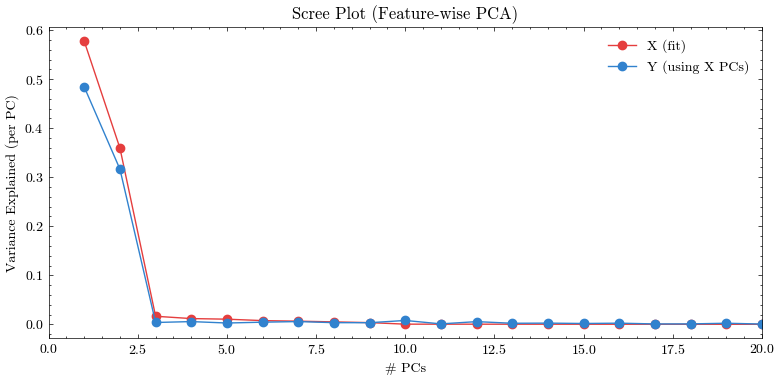

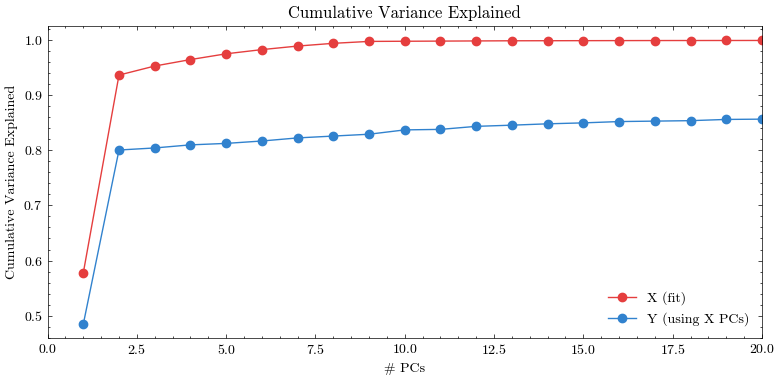

In [120]:
evr_X, cev_X, evr_Yx, cev_Yx, pca = pca_cross_variance_featurewise(test_task_0_stim, test_task_final_stim, \
                                                                   n_components=N, plot=True, center_on="X")

X2d: (350, 300); Y2d: (350, 300)


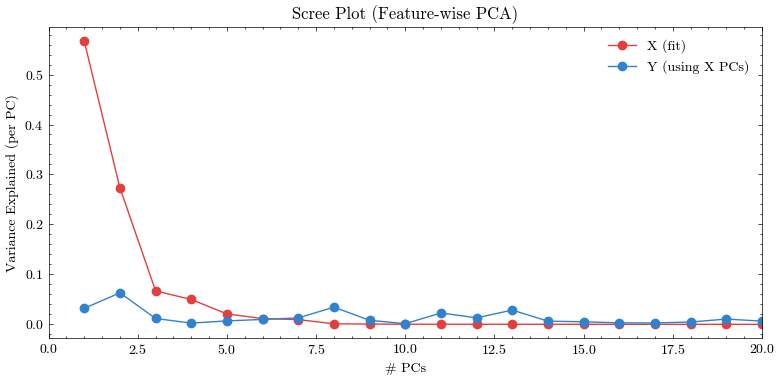

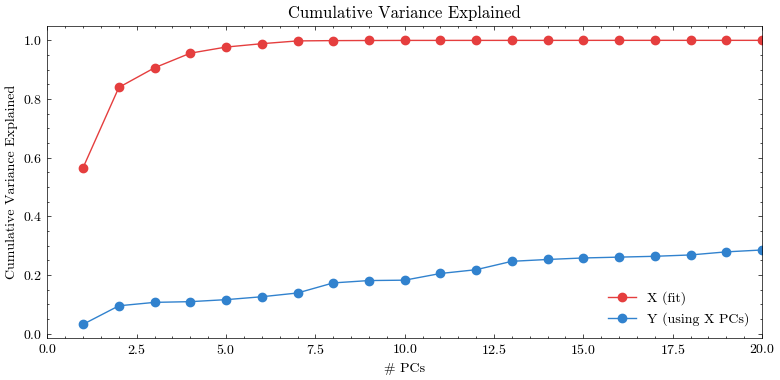

In [121]:
evr_X, cev_X, evr_Yx, cev_Yx, pca = pca_cross_variance_featurewise(test_task_1_go, test_task_final_go, \
                                                                   n_components=N, plot=True, center_on="X")